## Exchange Rate Forecasting
This dataset contains information about an exchange rate (OT) from  Mendeley dataset archives.  There are no available information from the archive about what the columns are and how they relate to the target.  Therefore i will treat this as synthetic dataset. The data however contains dates starting from 01 Jan 1990 until 10 Oct 2010.  


#### Problem and horizon definition
I will use the dataset to forcast the exchange rate (target) using a horizon (h) window of 30 days.   The choice of forecasting the exchange rate for the next 30 days is not ideal in a forex trading market. However for learning purposes of using lag information for forecasting, I will be forecasting the exchange rates for the next 30 days. 
Because a typical forex trading price is most reliable for predicting the next day or two trading price, I would expect that the accuracy of the prediction will fall off as the days increases.  
Therefore in addition to predicting the trading exchange, I will also forecast the 5% and 95% percentile trading prices for the next 30 days which will be more ideal for a trading forecast. 

**Models**    
I will be using a baseline (naive) model for initial forecasting and then compare the baseline performance with other improved models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,0.5930
1,1990/1/2 0:00,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,0.5940
2,1990/1/3 0:00,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,0.5973
3,1990/1/4 0:00,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.523834,0.5970
4,1990/1/5 0:00,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.527426,0.5985


In [3]:
df.shape

(7588, 9)

In [4]:
df.dtypes

date     object
0       float64
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
OT      float64
dtype: object

In [5]:
df.index

RangeIndex(start=0, stop=7588, step=1)

All the columns of the dateset are of float type and there are a total of 7588 rows and 9 columns. Between 01 jan 1990 and 10 oct 2010, there are 7588 days including the end date.  This means we do not have any missing day in our data 

In [6]:
df.isnull().sum()

date    0
0       0
1       0
2       0
3       0
4       0
5       0
6       0
OT      0
dtype: int64

In [7]:
## Converting the date column to datetime and setting it as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [8]:
df.head()

,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,0.5930
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,0.5940
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,0.5973
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.523834,0.5970
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.527426,0.5985


### EDA

In [9]:
## setting plot parameters
plt.rc('axes',
       labelcolor='0.40',
       labelsize=8,
       labelweight='normal', 
       titlecolor='0.25', 
       titlesize=12,
       titleweight='bold', 
      )

plt.rc('figure',
       labelsize=8, 
       labelweight='normal', 
       titlesize=12,
       titleweight='bold',
      )

sns.set_theme()

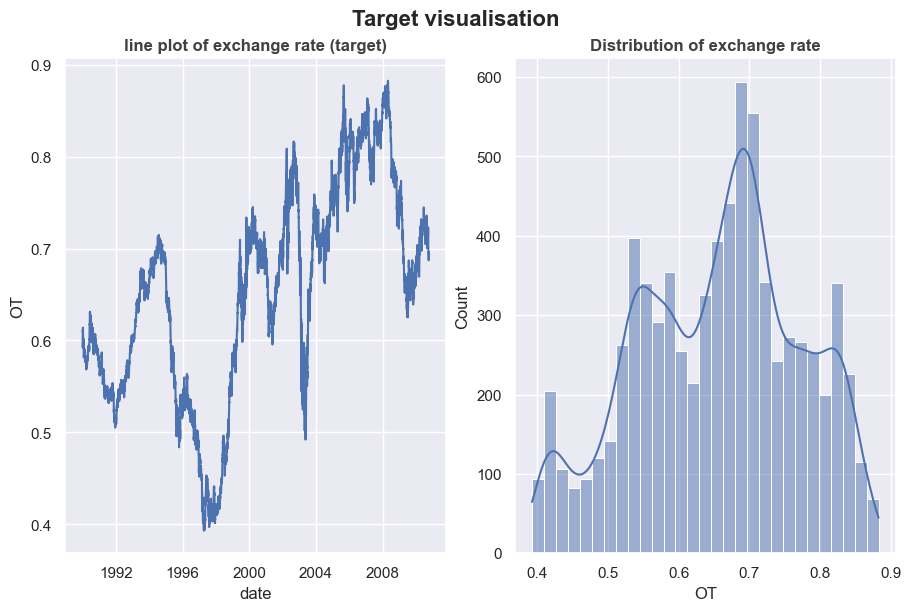

In [10]:
### ploting the target column

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[9,6], layout='constrained')
fig.suptitle('Target visualisation', c='0.15', fontsize=16)
## lineplot
axd = sns.lineplot(df, x=df.index, y='OT', ax=ax0)
axd.set_title('line plot of exchange rate (target)')


axs = sns.histplot(df, x='OT', kde=True, ax=ax1)
axs.set_title('Distribution of exchange rate')
plt.show()

The distribution of the exchange rates shows a gaussian distribution between 0.4 to about 0.88.  The lineplot shows an upward trend over the years and also shows a significant drop in the year between 1997 and 1998.  Interestingly, the period between 1997 and 1999 was a period of `Asian Financial Crises` which started with currency devaluations and saw a big drop in exchange rate. By 1998, this financial crisis spread beyond Asian market into Russia and Latin America.  By 1999, most of the affected markets started recovering which saw a big surge in exchange rate into the year 2000.      
It is important to note that there is no available information of which currency this data is for, however, because of how financial markets work, a big change in one area of financial market can have an impact on another sector of financial market. Therefore, although there is no information which currency data this is, an drop in Asian financial market could still impact the data even if the data is not from an Asian financial market. 

In [11]:
import statsmodels.api as sm
import statsmodels

In [12]:
## lags and rolling window visualisations
y = df['OT']

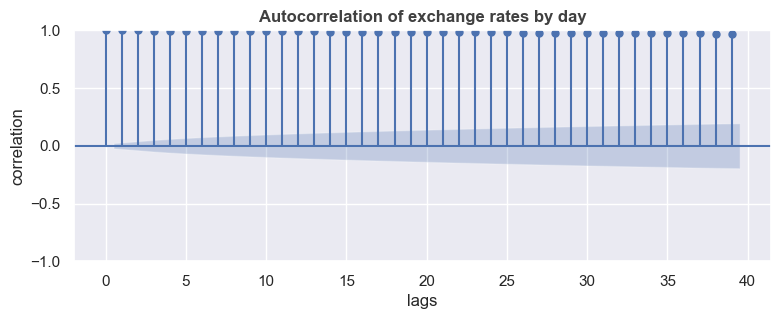

In [13]:
# Autocorrelation of y
fig, ax = plt.subplots(figsize=(9, 3))
sm.graphics.tsa.plot_acf(y, ax=ax)
ax.set_title('Autocorrelation of exchange rates by day')
ax.set_xlabel('lags')
ax.set_ylabel('correlation')
plt.show()

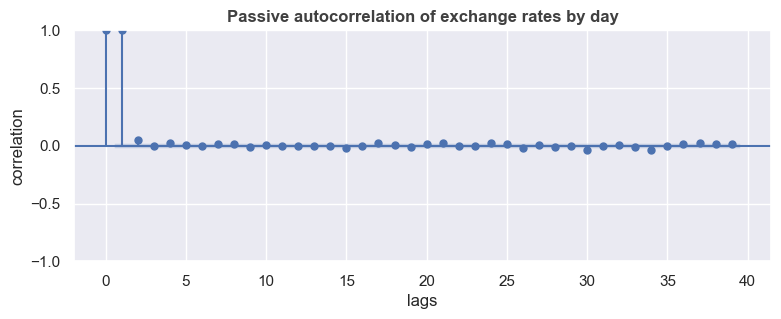

In [14]:
# Passive autocorrelation
fig, ax = plt.subplots(figsize=(9, 3))
sm.graphics.tsa.plot_pacf(y, ax=ax)
ax.set_title('Passive autocorrelation of exchange rates by day')
ax.set_xlabel('lags')
ax.set_ylabel('correlation')
plt.show()

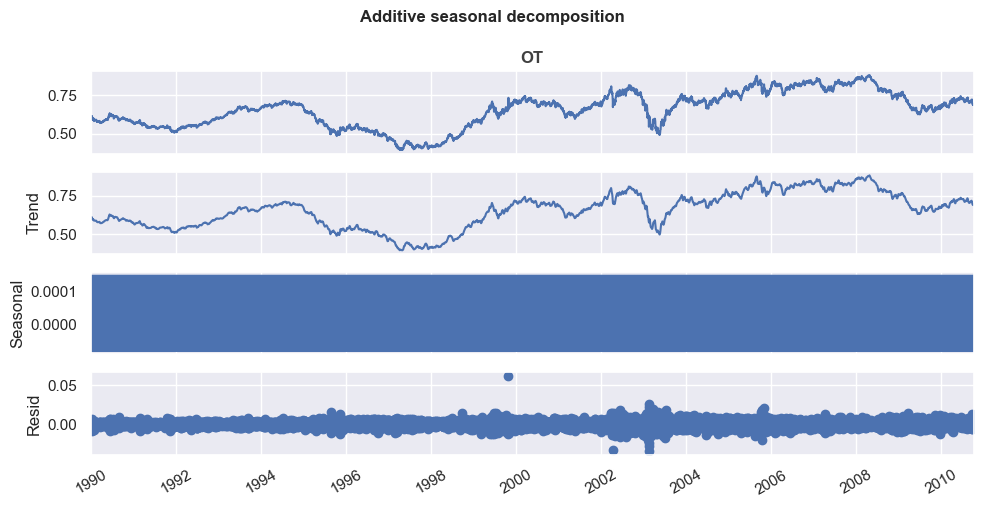

In [15]:
## seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
y_decomp = seasonal_decompose(y, model='add')

ax = y_decomp.plot()
ax.set(figheight=5, figwidth=10)
ax.suptitle('Additive seasonal decomposition')
ax.tight_layout()
plt.tick_params(axis='x', labelrotation=30.0)
plt.show()


In [16]:
## rolling windows
df_new = df[['OT']].copy()
df_new['7days_rolling_mean'] = df['OT'].rolling(window=7, min_periods=1).mean()
df_new['7day_rolling_std'] = df['OT'].rolling(window=7, min_periods=1).std()
df_new['percent_change'] = df['OT'].pct_change()

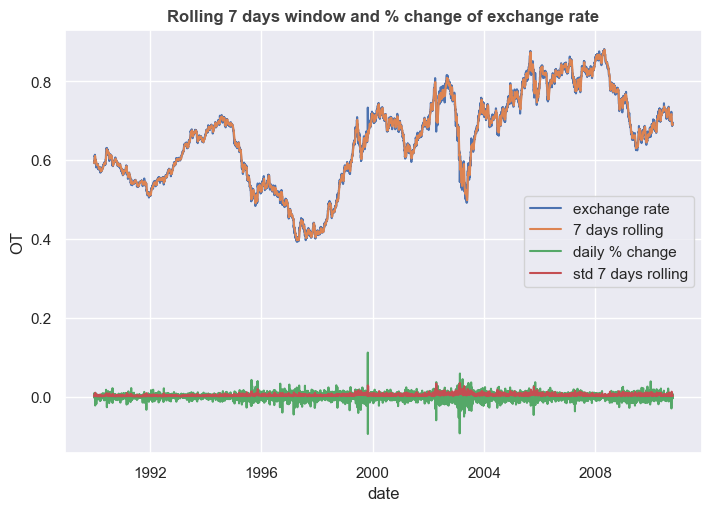

In [17]:
fig, ax = plt.subplots(figsize=[7,5], layout='constrained')
#fig.suptitle('Target visualisation', c='0.15', fontsize=16)

ax = sns.lineplot(df_new, x=df_new.index, y='OT', ax=ax, label='exchange rate')
ax = sns.lineplot(df_new, x=df_new.index, y='7days_rolling_mean', ax=ax, label='7 days rolling')
ax = sns.lineplot(df_new, x=df_new.index, y='percent_change', ax=ax, label='daily % change')
ax = sns.lineplot(df_new, x=df_new.index, y='7day_rolling_std', ax=ax, label='std 7 days rolling')

ax.set_title('Rolling 7 days window and % change of exchange rate')
plt.show()


##### summary for correlation analysis
The passive correlation reveals that the immediate past day (lag 1) has very strong autocorrelation with the present exchange rates and the seasonal decomposition shows that there is trend in our data but not seasonality. The 7 days rolling window plot reveals that there is not lots of noise in the data rather they move very closely together with exchange rate confirming that the immediate past day will have strong effect on the exchange rate.  The standard deviation and daily percentage change also reveal volatility clustering indicating that when there is a big % change in exchange rate, there is also an increase volatility.  

### Baseline Forecast
My first model will be a naive baseline forecast and a seasonal naive forecast using lag days trading values. 

In [18]:
def naive_model(series, horizon=30):
    ''' This function is to generate
    data using previous trading value'''
    last_price = series.iloc[-1]
    trading_price = np.full(horizon, last_price)
    return pd.Series(trading_price, 
                     index=pd.date_range(start=series.index[-1]+ pd.Timedelta(days=1), 
                     periods = horizon,
                    freq = 'D',
                                        )
                    )

def seasonal_naive(series, series_length, horizon=30):
    ''' 
    This function returns the naive forecast 
    while taking into account the seasonal length of 
    the data. If the series is not up to the seasonal
    length, then a naive model forecast is returned. 
    '''
    if len(series)< series_length:
        
        return naive_model(series, horizon)
        
    last_season = series.iloc[-series_length:]
    forecast_period = pd.date_range(start=series.index[-1]+pd.Timedelta(days=1),
                                    periods=horizon,
                                    freq='D'
                                   )
    return pd.Series(np.array(last_season[:30]), 
                     index=forecast_period)


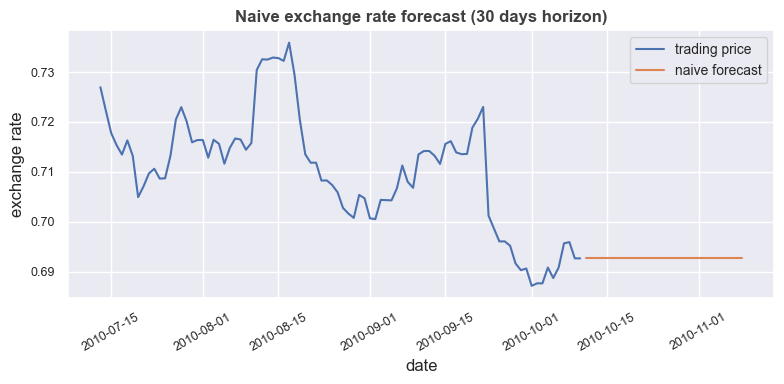

In [19]:
## naive forecast 
naive_forecast = naive_model(df['OT'])

#plotting the naive forecast
last_90_days = df['OT'].iloc[-90:]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(last_90_days, label='trading price')
ax.plot(naive_forecast, label='naive forecast')
ax.tick_params(axis='x', which='major', rotation=30, labelsize=9)
ax.set(title='Naive exchange rate forecast (30 days horizon)',
       ylabel='exchange rate', 
       xlabel='date'
      )
ax.tick_params(axis='y', which='major', labelsize=9)
plt.legend(fontsize='small')
plt.tight_layout()

plt.show()

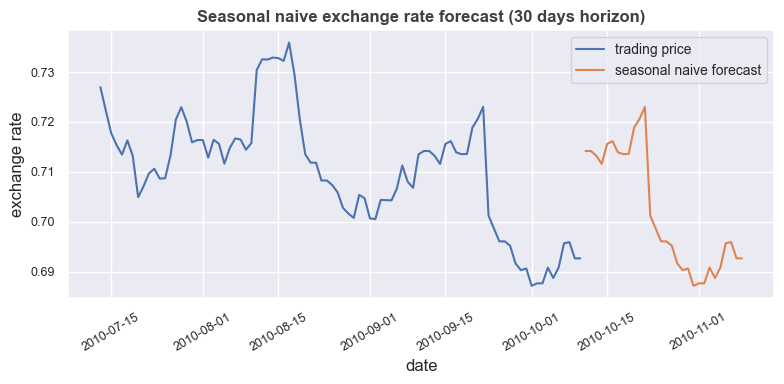

In [20]:
## Seasonal naive forecast 
seasonal_naive_forecast = seasonal_naive(df['OT'], series_length=30)

#plotting the seasonal naive forecast
last_90_days = df['OT'].iloc[-90:]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(last_90_days, label='trading price')
ax.plot(seasonal_naive_forecast, label='seasonal naive forecast')
ax.tick_params(axis='x', which='major', rotation=30, labelsize=9)
ax.set(title='Seasonal naive exchange rate forecast (30 days horizon)',
       ylabel='exchange rate', 
       xlabel='date'
      )
ax.tick_params(axis='y', which='major', labelsize=9)

plt.tight_layout()
plt.legend(fontsize='small')
plt.show()

The naive and seasonal naive forecasts purely used the exchange rates of the day prior and 30 days prior to forecast the next 30 days trading price.  
Comparing the plots of the trading prices in the last 90 days and the naive forecasts show that the baseline models could not capture the trends in the data purely based on the prior days trading prices.   
Therefore an improved model with better feature engineering will be used to compare with the naive forecasts. 

### Feature Engineering
I will be using a forecasting horizon of 30 days which means the data will be shifted for no less than 30 days.    
The feature engineering will be used to generate different  lags for up to 90 days in other to capture different momentum on signals in the exchange rate.    
I will also be generating a custom split for the timeseries train and test data for cross validation.  The split will be 5 fold which will ensure a minimum of 30 days horizon is observed in each split. The folds will be increasing from the last train split which means that fold 2 will include the train and test window of fold 1, and so on with fold 3 to fold 5. 

In [21]:
## functions for creating lags and spliting date
def create_lags(df, horizon = 30):
    """ 
    Preparing data using the forecasting horizon
    """
    df = df.copy()
    df['target'] = df['OT'].shift(-horizon) # predicting 30 days ahead

    # shifting all features by horizon to avoid leakage
    feature_lags = [1, 2, 7, 14, 30, 60, 90]
    for lag in feature_lags:
        df[f'lag_{lag}d'] = df['OT'].shift(lag+horizon -1)

    # rolling statistics (ending at prediction time)
    windows = [7, 30, 90]
    for window in windows:
        # shifting by horizon to use only past data
        df[f'mean_{window}d'] = df['OT'].shift(horizon).rolling(window).mean()
        df[f'std_{window}d'] = df['OT'].shift(horizon).rolling(window).std()
        #df['rolling_7d'] = df['OT'].shift(horizon).rolling(7).mean()
        #df['volatility_30d'] = df['OT'].shift(horizon).rolling(30).std()

    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    df = df.dropna()
    return df


def create_splits(X, y, horizon=30, n_splits=5):
    """
    splits that observe horizon forecast
    """
    splits = []
    n_samples = len(X)

    gap = horizon # at least horizon days between train and test
    test_size = horizon * 4  # testing for at least 4 prediction cycles

    for i in range(n_splits):
        train_end = n_samples  - (n_splits - i) * (test_size + gap)  # walking backwards from last test date (n_splits - i)
        test_start = train_end + gap
        test_end = test_start + test_size

        # checking train and test data are within ranges of available data
        if train_end >= 365 * 2 and test_end <= n_samples:
            train_idx = list(range(train_end))
            test_idx = list(range(test_start, test_end))
            splits.append((train_idx, test_idx))

    return splits

def check_split_range(train_idx, test_idx, X, horizon=30):
    
    max_train_date = X.iloc[train_idx].index.max()
    min_test_date = X.iloc[test_idx].index.min()

    print(f'Max train date {max_train_date}')
    print(f'Min test date {min_test_date}')
    print(f'Gap {(min_test_date - max_train_date).days} days')

    if (min_test_date - max_train_date).days < horizon:
        print('Not enough gap between train and test date')


In [22]:
df_lags = create_lags(df_new[['OT']])

X = df_lags.drop(['OT', 'target'], axis=1)
y = df_lags['target']

all_splits = create_splits(X, y)

for split in all_splits:
    check_split_range(split[0], split[1], X)


Max train date 2008-08-21 00:00:00
Min test date 2008-09-21 00:00:00
Gap 31 days
Max train date 2009-01-18 00:00:00
Min test date 2009-02-18 00:00:00
Gap 31 days
Max train date 2009-06-17 00:00:00
Min test date 2009-07-18 00:00:00
Gap 31 days
Max train date 2009-11-14 00:00:00
Min test date 2009-12-15 00:00:00
Gap 31 days
Max train date 2010-04-13 00:00:00
Min test date 2010-05-14 00:00:00
Gap 31 days


In [23]:
from collections import defaultdict
split_dict = defaultdict(list)

## Showing fold boundaries table

for fold, split in enumerate(all_splits):
    fold = fold+1
    min_train_date = X.iloc[split[0]].index.min()
    max_train_date = X.iloc[split[0]].index.max()
    min_test_date = X.iloc[split[1]].index.min()
    max_test_date = X.iloc[split[1]].index.max()
    gap = min_test_date - max_train_date

    split_dict['CV fold'].append(fold)
    split_dict['Train start date'].append(min_train_date)
    split_dict['Train end date'].append(max_train_date)
    split_dict['Test start date'].append(min_test_date)
    split_dict['Test end date'].append(max_test_date)
    split_dict['Gap in days'].append(gap)
   
print("\nTable of Cross validation folds boundaries")
pd.DataFrame(split_dict).set_index('CV fold')


Table of Cross validation folds boundaries


,Train start date,Train end date,Test start date,Test end date,Gap in days
CV fold,,,,,
1,1990-04-30,2008-08-21,2008-09-21,2009-01-18,31 days
2,1990-04-30,2009-01-18,2009-02-18,2009-06-17,31 days
3,1990-04-30,2009-06-17,2009-07-18,2009-11-14,31 days
4,1990-04-30,2009-11-14,2009-12-15,2010-04-13,31 days
5,1990-04-30,2010-04-13,2010-05-14,2010-09-10,31 days


In [24]:
X.head()

,lag_1d,lag_2d,lag_7d,lag_14d,lag_30d,lag_60d,lag_90d,mean_7d,std_7d,mean_30d,std_30d,mean_90d,std_90d,dayofweek,month,quarter
date,,,,,,,,,,,,,,,,
1990-04-30,0.5721,0.5747,0.5685,0.5827,0.5783,0.5815,0.5930,0.572000,0.001924,0.577223,0.003673,0.587874,0.010864,0,4,2
1990-05-01,0.5739,0.5721,0.5708,0.5828,0.5790,0.5850,0.5940,0.572771,0.001251,0.577077,0.003716,0.587662,0.010949,1,5,2
1990-05-02,0.5700,0.5739,0.5727,0.5818,0.5778,0.5883,0.5973,0.572657,0.001477,0.576777,0.003914,0.587396,0.011084,2,5,2
1990-05-03,0.5708,0.5700,0.5726,0.5817,0.5770,0.5898,0.5970,0.572386,0.001634,0.576543,0.004057,0.587101,0.011170,3,5,2
1990-05-04,0.5725,0.5708,0.5726,0.5755,0.5790,0.5887,0.5985,0.572371,0.001633,0.576393,0.004122,0.586829,0.011224,4,5,2


In [25]:
display(X.shape)
display(y.shape)

(7439, 16)

(7439,)

#### Feature importances

In [26]:
from sklearn.feature_selection import mutual_info_regression

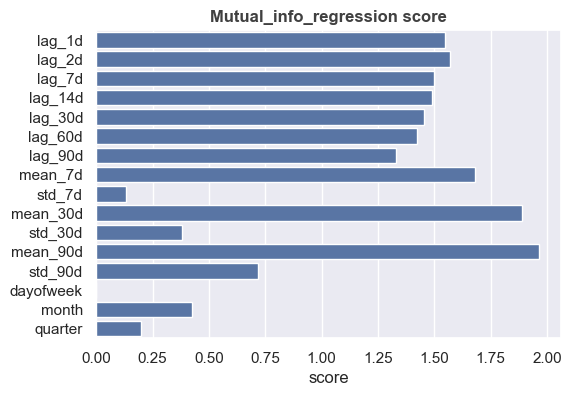

In [27]:
mi = mutual_info_regression(X, y, random_state=212)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=mi, y=X.columns, ax=ax)
ax.set(title = 'Mutual_info_regression score',
      ylabel='', 
      xlabel='score')
plt.show()

The mutual information regression shows high scores for the lag days starting from day 1 and decreasing by day. As well, The rolling means for 7, 30 and 90 days together with their std show increasing feature importances. Overall, the past data information show consistency in importance for the data. 


### Improved Model (Linear Model)
My first improved model will be `linear model` which will be modelled only with lag features for the data.  This will then be compared against the baseline model

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate

In [29]:

train_idx, test_idx = all_splits[0]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [30]:
ridgecv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 5], 
                  scoring = 'neg_mean_squared_error',
                 )

ridgecv.fit(X_train, y_train)
ridgecv.alpha_

np.float64(0.01)

In [31]:
### prediction
y_pred = ridgecv.predict(X_test)
linear_MAE = mean_absolute_error(y_test, y_pred)
print(f'Linear model prediction MAE {linear_MAE:.2g}')
linear_MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(f'Linear model prediction MAPE {linear_MAPE:.2g}')
linear_MSE = mean_squared_error(y_test, y_pred)
print(f'Linear model prediction MSE {linear_MSE:.2g}')

Linear model prediction MAE 0.023
Linear model prediction MAPE 0.031
Linear model prediction MSE 0.00068


In [32]:
linear_model_cv_scores = cross_validate(ridgecv, X, y, cv=all_splits, 
                           scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'],
                           n_jobs=-1)

linear_model_cv_scores

{'fit_time': array([0.01913738, 0.01794052, 0.02165723, 0.01805949, 0.01680088]),
 'score_time': array([0.00537586, 0.0060699 , 0.00409985, 0.00554943, 0.00306773]),
 'test_neg_mean_absolute_error': array([-0.02315179, -0.04047752, -0.01536402, -0.02364123, -0.01382954]),
 'test_neg_mean_absolute_percentage_error': array([-0.03101798, -0.0608136 , -0.02325548, -0.03354881, -0.01943851]),
 'test_neg_mean_squared_error': array([-0.00068337, -0.00228309, -0.00031993, -0.00076076, -0.00025617])}

In [33]:
def linear_model_cv_results():
    print(f"CV linear model MAPE scores: {linear_model_cv_scores['test_neg_mean_absolute_error'].mean():.2g} +/- {linear_model_cv_scores['test_neg_mean_absolute_error'].std():.2g}")
    print(f"CV linear model MAPE scores: {linear_model_cv_scores['test_neg_mean_absolute_percentage_error'].mean():.2g} +/- {linear_model_cv_scores['test_neg_mean_absolute_percentage_error'].std():.2g}")
    print(f"CV linear model MSE scores: {linear_model_cv_scores['test_neg_mean_squared_error'].mean():.2g} +/- {linear_model_cv_scores['test_neg_mean_squared_error'].std():.2g}")

linear_model_cv_results()

CV linear model MAPE scores: -0.023 +/- 0.0095
CV linear model MAPE scores: -0.034 +/- 0.015
CV linear model MSE scores: -0.00086 +/- 0.00074


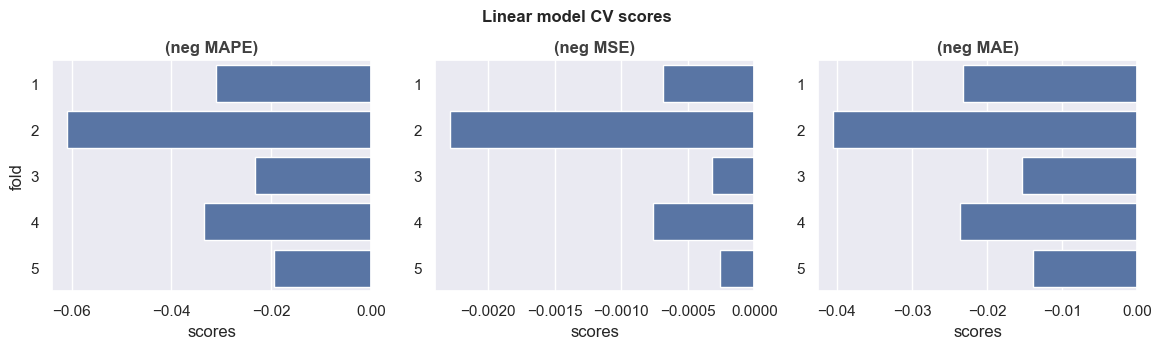

In [34]:
folds = ['1', '2', '3', '4', '5']
fig, (ax0, ax1, ax2) = plt.subplots(ncols = 3, figsize=(14, 3))
plt.suptitle('Linear model CV scores',y=1.05)

sns.barplot(x=linear_model_cv_scores['test_neg_mean_absolute_percentage_error'], y=folds, ax=ax0)
ax0.set_title('(neg MAPE)')
ax0.set_ylabel('fold')
ax0.set_xlabel('scores')

sns.barplot(x=linear_model_cv_scores['test_neg_mean_squared_error'], y=folds, ax=ax1)
ax1.set_title('(neg MSE)')
ax1.set_xlabel('scores')

sns.barplot(x=linear_model_cv_scores['test_neg_mean_absolute_error'], y=folds, ax=ax2)
ax2.set_title('(neg MAE)')
ax2.set_xlabel('scores')

plt.show()

##### Linear Model performance summary 
The performance of the Linear model ridgecv has a percentage score of 3.4% which falls within the good bracket (1-5%) for forex forcasting. The folds cross validation scores are similar except for fold 2 which is scored a lot lower than the rest of the folds although the overall difference is not greater than 0.05.  


### Quantile prediction (Non Linear Model)
An absolute prediction of the forex price using a 30 day horizon is too ambitious as stated earlier. Rather it would be better to predict the quantiles of what the forex price should be and would expect that the true y values (target) will be within this quantile. Therefore, the next model will be predicting 5%, 50% and 95% quantiles using gradient boosting method.  The quantile prediction will be evaluated with Pinball loss (quantile loss) as well as the other metrics used for cross validation of the linear model. 

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, make_scorer
from collections import defaultdict
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV

In [36]:
## computing parameters for the quantile predictions

#scores = defaultdict(list)

def score_metric(scorer, alpha=None, greater_is_better=False):
    if alpha == None:
        return scorer
    return make_scorer(scorer, 
                         alpha = alpha, 
                         greater_is_better=greater_is_better
                        )

# search parameter for grid
search_params = dict(
    learning_rate = [0.01, 0.05, 0.1], 
    max_depth = [None, 2, 8, 20], 
    min_samples_leaf = [5, 20, 50],
    max_iter=[150, 500, 1000]

)

## grid search for 0.05 quantile

neg_mean_pinball_5p = score_metric(mean_pinball_loss, alpha=0.05)

hgbr_5p = HistGradientBoostingRegressor(loss='quantile', quantile=0.05, random_state=0)

gridsearch_5p = RandomizedSearchCV(
    hgbr_5p, 
    param_distributions=search_params, 
    scoring=neg_mean_pinball_5p,
    n_iter = 20,
    n_jobs = -1,
    random_state=0).fit(X_train, y_train)  # doing a simple randomized search on the first split of the data only to minimize runtime

hgbr_quantile_05 = gridsearch_5p.best_estimator_
hgbr_quantile_05

HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=8,
                              max_iter=500, quantile=0.05, random_state=0)

In [37]:
## simple model estimator def 

def make_estimators(**args):
    gridsearch = clone(gridsearch_5p).set_params(**args)
    gridsearch.fit(X_train, y_train)
    return gridsearch.best_estimator_

# defining different quantiles and mse model params

models = {'hgbr_quantile_95': dict(estimator__quantile = 0.95, 
                               scoring = score_metric(mean_pinball_loss, alpha=0.95)),
          'hgbr_quantile_50': dict(estimator__quantile = 0.50, 
                               scoring = score_metric(mean_pinball_loss, alpha=0.5)),
          'hgbr_mse': dict(estimator__loss = 'squared_error',
                           estimator__quantile = None,
                           estimator__l2_regularization=0,
                           estimator__categorical_features=None,
                           scoring = 'neg_mean_squared_error'),
         }

opt_models = defaultdict(set)

for model, params in models.items():
    opt_models[model].add(make_estimators(**params))

### updating the set with the model for quantile 0.05
opt_models['hgbr_quantile_05'].add(hgbr_quantile_05)

display(opt_models)


defaultdict(set,
            {'hgbr_quantile_95': {HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=2,
                                            max_iter=1000, quantile=0.95, random_state=0)},
             'hgbr_quantile_50': {HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=2,
                                            max_iter=500, quantile=0.5, random_state=0)},
             'hgbr_mse': {HistGradientBoostingRegressor(categorical_features=None, l2_regularization=0,
                                            max_depth=20, max_iter=1000, min_samples_leaf=50,
                                            random_state=0)},
             'hgbr_quantile_05': {HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=8,
                                            max_iter=500, quantile=0.05, random_state=0)}})

In [38]:
## ftting all models

cv_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'MAPE' : make_scorer(mean_absolute_percentage_error), 
    'MSE': make_scorer(mean_squared_error),
    'pinball_loss_05': make_scorer(mean_pinball_loss, alpha=0.05), 
    'pinball_loss_50': make_scorer(mean_pinball_loss, alpha=0.50), 
    'pinball_loss_95': make_scorer(mean_pinball_loss, alpha=0.95)
}



def model_scores(cv_results, model_cv_results, metric):
    """ compute each metric result from the cross validation 
    and append the results into the list of dictionary
    """
    model_cv_results[metric].append(f"{value.mean():.2g} +/- {value.std():.2g}")

    
model_cv_results = defaultdict(list) # list of dict to store model cv results

for name, model in sorted(opt_models.items()):
    for func in model:
        cv_results = cross_validate(
            func, 
            X, y, 
            cv = all_splits,
            scoring = cv_metrics, 
            n_jobs=-1
        )
    time = cv_results['fit_time']
        
    model_cv_results['model'].append(name)
    model_cv_results['fit_time'].append(f"{time.mean():.2f} +/- {time.std():.2g} s")

    ## computing cv_metrics
    for key, value in cv_results.items():
        if key.startswith("test_"):
            metric = key.split("test_")[1]
            #model_cv_results[metric].append(f"{value.mean():.2g} +/- {value.std():.2g}")
            model_scores(cv_results, model_cv_results, metric)
            
        

In [39]:
def min_score(score):
    min_score = score.min()
    return ['font-weight: bold' if num == min_score else '' for num in score]
    
display(pd.DataFrame(model_cv_results).set_index('model').style.apply(min_score, axis=1))
print()
linear_model_cv_results()

,fit_time,MAE,MAPE,MSE,pinball_loss_05,pinball_loss_50,pinball_loss_95
model,,,,,,,
hgbr_mse,3.32 +/- 0.024 s,0.031 +/- 0.016,0.044 +/- 0.023,0.0016 +/- 0.0014,0.015 +/- 0.013,0.016 +/- 0.0082,0.016 +/- 0.011
hgbr_quantile_05,3.36 +/- 0.036 s,0.049 +/- 0.025,0.069 +/- 0.033,0.0035 +/- 0.0028,0.0028 +/- 0.00089,0.025 +/- 0.013,0.047 +/- 0.025
hgbr_quantile_50,0.78 +/- 0.012 s,0.027 +/- 0.017,0.039 +/- 0.026,0.0013 +/- 0.0014,0.02 +/- 0.02,0.014 +/- 0.0086,0.0067 +/- 0.0054
hgbr_quantile_95,1.52 +/- 0.013 s,0.063 +/- 0.026,0.092 +/- 0.04,0.005 +/- 0.0038,0.06 +/- 0.025,0.032 +/- 0.013,0.0032 +/- 0.0013



CV linear model MAPE scores: -0.023 +/- 0.0095
CV linear model MAPE scores: -0.034 +/- 0.015
CV linear model MSE scores: -0.00086 +/- 0.00074


In [40]:
ridge_metrics = [{'model':'ridgecv', 
          'fit_time': f"{abs(linear_model_cv_scores['fit_time'].mean()):.2g} +/- {linear_model_cv_scores['fit_time'].std():.2g} s",
          'MAE': f"{abs(linear_model_cv_scores['test_neg_mean_absolute_error'].mean()):.2g} +/- {linear_model_cv_scores['test_neg_mean_absolute_error'].std():.2g}",
          'MAPE': f"{abs(linear_model_cv_scores['test_neg_mean_absolute_percentage_error'].mean()):.2g} +/- {linear_model_cv_scores['test_neg_mean_absolute_percentage_error'].std():.2g}",
          'MSE': f"{abs(linear_model_cv_scores['test_neg_mean_squared_error'].mean()):.2g} +/- {linear_model_cv_scores['test_neg_mean_squared_error'].std():.2g}"
         }
        ]

In [41]:
# Putting together all model results
All_model_results = pd.concat([pd.DataFrame(model_cv_results).set_index('model'),
           pd.DataFrame(ridge_metrics).set_index('model')])
All_model_results

,fit_time,MAE,MAPE,MSE,pinball_loss_05,pinball_loss_50,pinball_loss_95
model,,,,,,,
hgbr_mse,3.32 +/- 0.024 s,0.031 +/- 0.016,0.044 +/- 0.023,0.0016 +/- 0.0014,0.015 +/- 0.013,0.016 +/- 0.0082,0.016 +/- 0.011
hgbr_quantile_05,3.36 +/- 0.036 s,0.049 +/- 0.025,0.069 +/- 0.033,0.0035 +/- 0.0028,0.0028 +/- 0.00089,0.025 +/- 0.013,0.047 +/- 0.025
hgbr_quantile_50,0.78 +/- 0.012 s,0.027 +/- 0.017,0.039 +/- 0.026,0.0013 +/- 0.0014,0.02 +/- 0.02,0.014 +/- 0.0086,0.0067 +/- 0.0054
hgbr_quantile_95,1.52 +/- 0.013 s,0.063 +/- 0.026,0.092 +/- 0.04,0.005 +/- 0.0038,0.06 +/- 0.025,0.032 +/- 0.013,0.0032 +/- 0.0013
ridgecv,0.019 +/- 0.0016 s,0.023 +/- 0.0095,0.034 +/- 0.015,0.00086 +/- 0.00074,NaN,NaN,NaN


#### summary of improved models predictions
The overall cross validation results of the quantile predictions are good however, none of the models performed better than the linear RidgeCV model results.   
Looking at each model result for the quantile predictions, the loss that minimises the metrics or minimum metric error for each model is obtained when the model is trained with that error metric except in `hgbr_quantile_50`  model where MSE error was the lowest even though it was not the error metric for the model. However, if you look at the entire rows for hgbr_quantile_50, you would observe that the next lowest score after MSE was pinball_loss_50, emphasizing the impact of the error metric on each model.

Looking at the MAPE columns alone, the overall percentage error for all models was between 3.4% to 9.2%. The lowest percentage error was obtained with median prediction model `hgbr_quantile_50` in the nonlinear models which happens to have the the lowest MSE in the entire nonlinear model. The MAPE results is also similar to the linear ridgeCV model whose MAPE was 3.4% also. This similarities points that the model performance is better when combined with mean squared error for predicting mean values. 

##### plotting the test predictions using a single split

In [42]:
### using one of the split index for predictions
Test_and_predictions = pd.DataFrame(y_test)
Test_and_predictions = pd.concat([Test_and_predictions, (pd.DataFrame(ridgecv.predict(X_test), index=y_test.index).rename(columns={0:'ridgecv'}))], axis=1)

for name, models in sorted(opt_models.items()):
    for model in models:
        prediction = model.predict(X_test)
    prediction = pd.DataFrame(prediction, index=y_test.index).rename(columns={0:name})
    Test_and_predictions = pd.concat([Test_and_predictions, prediction], axis=1)

In [43]:
Test_and_predictions.head()

,target,ridgecv,hgbr_mse,hgbr_quantile_05,hgbr_quantile_50,hgbr_quantile_95
date,,,,,,
2008-09-21,0.777122,0.760974,0.825236,0.692705,0.808535,0.837254
2008-09-22,0.773365,0.764682,0.822551,0.692705,0.808535,0.838214
2008-09-23,0.774114,0.775142,0.821439,0.692382,0.811994,0.839367
2008-09-24,0.778907,0.777282,0.814262,0.696462,0.813708,0.843215
2008-09-25,0.777847,0.777962,0.807658,0.699122,0.813708,0.842469


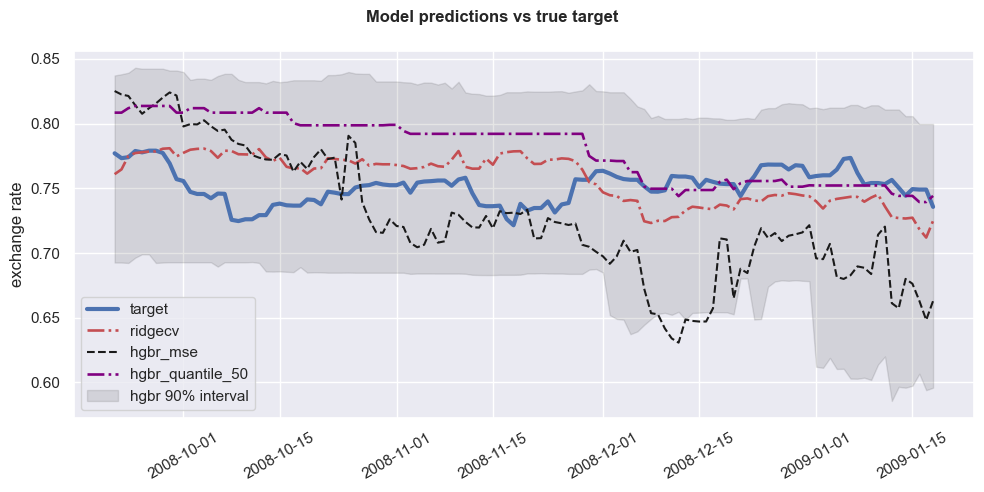

In [44]:
## plotting the predictions 
from cycler import cycler

color_cycler = (cycler(color=['b', 'r', 'k', 'purple']) +
                cycler(linestyle=['-', '-.', '--', '-.']) +
                cycler(lw=[3, 1.9, 1.5, 1.9]))

#test_columns = Test_and_predictions.columns
test_columns = ['target', 'ridgecv', 'hgbr_mse', 'hgbr_quantile_50',]
fig, ax = plt.subplots(figsize=(10, 5), layout='tight')
ax.set_prop_cycle(color_cycler)
plt.suptitle('Model predictions vs true target')
for column in test_columns:
    #if not column in ['hgbr_quantile_05', 'hgbr_quantile_95']:
    ax.plot(Test_and_predictions.index,
            Test_and_predictions[column],
            label=column
            )
ax.fill_between(Test_and_predictions.index, Test_and_predictions['hgbr_quantile_05'], 
                Test_and_predictions['hgbr_quantile_95'], alpha =0.1, color='black', label='hgbr 90% interval')
ax.set_ylabel('exchange rate')
plt.tick_params(axis='x', which='major', rotation=30)
plt.legend()
plt.show()

##### summary of results
Looking at the overall predictions of the test data, it is observed that all the median and mean prediction models started by overpredicting the data at the beginning and as the dates increases the curves got lower than the targets. However, all the models with slight exception for the gradient boosted model with mean squared error metric stayed within the 90% interval. Still the best predictions among all the models is the Linear model Ridgecv.  
The drop in curve also proves that it is indeed very ambitious to forecast the next 30 days horizon in the forex market because the market is very volatile and the data will be unreliable. This drop shows that the residuals increases as the forecasting days increases and the predictive ability of the lag features tails off very fast. 

Next I will explore the residuals for each models and predictions

In [45]:
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.ticker as ticker

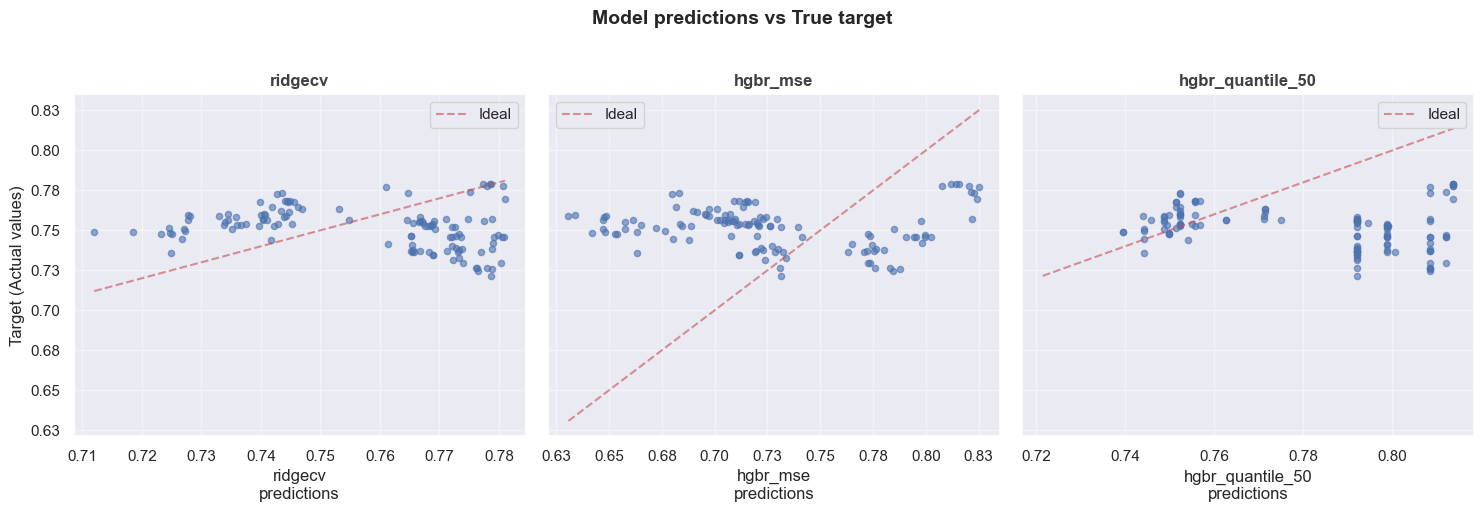

In [46]:
### Plotting residuals for mean and median predictions
models = ['ridgecv', 'hgbr_mse', 'hgbr_quantile_50',]
predictions = [np.array(Test_and_predictions['ridgecv']), 
             np.array(Test_and_predictions['hgbr_mse']),
             np.array(Test_and_predictions['hgbr_quantile_50'])]
target = np.array(Test_and_predictions['target'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for idx, (model, pred) in enumerate(zip(models, predictions)):
    ax = axes[idx]
    ax.scatter(pred, target, alpha=0.6, s=20)
    min_val = min(min(pred), min(target))
    max_val = max(max(pred), max(target))
    ax.plot([min_val, max_val], [min_val, max_val],
            'r--', alpha=0.6, label='Ideal')

    ax.set_xlabel(f'{model}\npredictions')
    if idx==0:
        ax.set_ylabel('Target (Actual values)')

    ax.set_title(model)

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    ax.grid(True, alpha=0.4)
    ax.legend()

plt.suptitle('Model predictions vs True target', size=14, y=1.02)
plt.tight_layout()
plt.show()
    

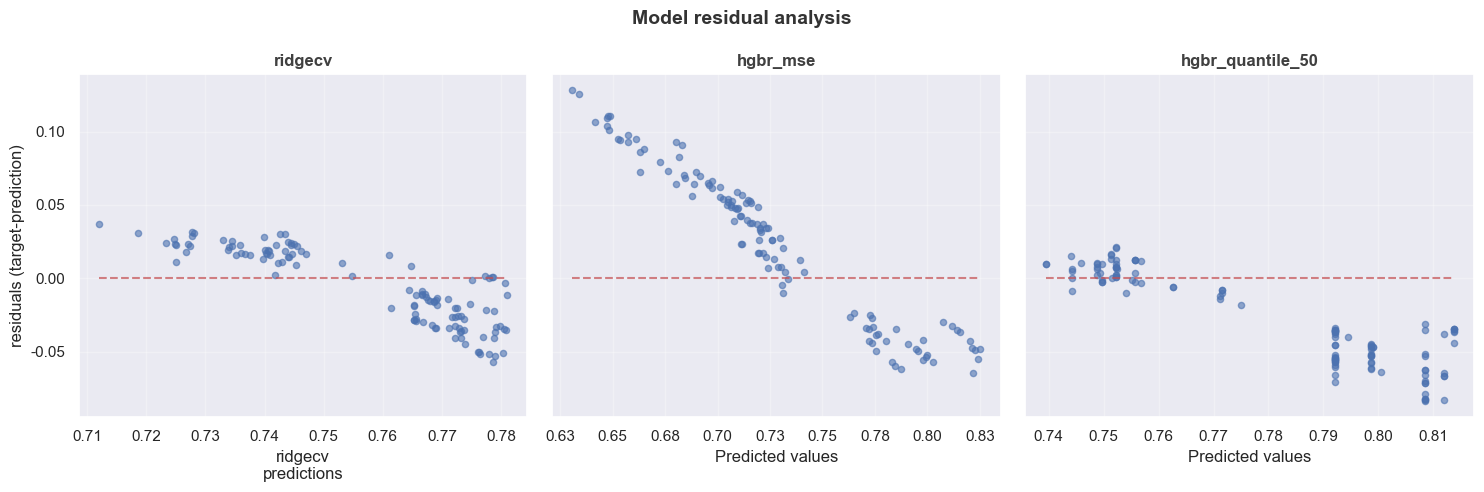

In [47]:
### Plotting residuals for mean and median predictions
predicted = ['ridgecv', 'hgbr_mse', 'hgbr_quantile_50',]

fig = plt.figure(figsize=(15,5), layout='tight')
plt.suptitle('Model residual analysis', c='0.2', size=14, )

for idx, column in enumerate(predicted): 
    if idx == 0:
        ax = plt.subplot(1, 3, idx+1)
        ax_1 = ax
    else: 
        ax = plt.subplot(1, 3, idx+1, sharey=ax_1)
        ax.tick_params(labelleft=False)
    PredictionErrorDisplay.from_predictions(
        y_true=Test_and_predictions['target'],
        y_pred = Test_and_predictions[column],
        kind='residual_vs_predicted', 
        scatter_kwargs={'alpha':0.6, 's':20, 'c':'b'},
        line_kwargs={'color':'r'},
        ax=ax)
    
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_ylabel('')
    if idx == 0:
        ax.set(xlabel= f'{column}\npredictions', 
              ylabel= 'residuals (target-prediction)')

    ax.grid(True, alpha=0.3)
    ax.set_title(column)


The plot of the actual versus predicted show that the ridgecv has good performance as the points follow the line better than all other models.  The quantile_50 model has also some modest performance and the least of the models is the quantile_mean_squared_error.  

This is also seen in the residual plots for the models with ridgecv meeting the liinear regression assumptions better. The HGBR_ means squared error residual indicates that the data was quantized and possible discretization. The performance of HGBR_ quantile_50 shows increasing variance with increased predictions

#### Best Model Recommendation
Based on all the three models used to predict the mean/median forex price, the best improved model is the RidgeCV regression model and has shown to learn the pattern in the data better than the HistGradientBoostingRegressor models. The signal is mostly linear autocorrelation (lag structure), so RidgeCV wins.  HGBR attempts to overfit the due to default binning used by the nonlinear model.  The residual plot for the ridgecv regression shows a spread between +0.05 and -0.05 with no obvious pattern. 

### Conclusion
In this timeseries forecasting, i have modelled the currency exchange data using past values and compared the performance of the baseline naive models with two types of models: a linear model (RidgeCV regression) and non-linear model (Ensemble - HistGradientBoostingRegressor).   
The objective of the forecasting was to predict the mean trading price with a 30 days horizon window.  However, it is important to note that it is not ideal to predict the trading price beyond the next 2 days in the Forex market but this was for learning purposes.   
Of all the models used to fit the data, the best performance was obtained with the RidgeCV linear regression model with a cross validation score of 0.00086 for mean squared error, 0.023 mean absolute error and 3.4% mean absolute percentage error.